In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import gc
import sys

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [2]:
a=1

In [3]:
def create_movie(field_time_out, monitor_lambdas,name='',type='t',log=False,path="",frames_per_second=1,rem_frames=False, normalize=True, a=5/3):
    frames = []

    max_values = field_time_out.max(axis=(0,1,2)) if normalize else 1

    field_time_out = field_time_out/max_values
    field_time_out['x'] = field_time_out['x']/a
    field_time_out['y'] = field_time_out['y']/a
    field_time_out['z'] = field_time_out['z']/a


    if log:
        field_log = np.log10((field_time_out))
        folder_pics = "logPics"
        
    else:
        field_log = ((field_time_out))
        folder_pics = "linPics"

    if not os.path.exists(f'{path}/{folder_pics}'):
            os.makedirs(f'{path}/{folder_pics}')
            print(f"Folder {path}/{folder_pics} created successfully.")




    for i in range(np.shape(field_time_out)[-1]):
        if os.path.isfile(f'{path}/{folder_pics}/frame_{i}.png'):
            frames.append(f'{path}/{folder_pics}/frame_{i}.png')
            continue
        try:
            fig, ax = plt.subplots(figsize=(14/2, 18/2))
            #fig, ax = plt.subplots(figsize=(12, 6))
            if type=="t":
                pcolormesh = (field_log).isel(t=i).squeeze().plot.pcolormesh(ax=ax,cmap="jet")
            else:
                pcolormesh = (field_log).isel(f=i).squeeze().plot.pcolormesh(ax=ax,cmap="jet")

            ax.set_aspect('auto', adjustable='box')
            #plt.ylim(-50,50)
            try:
                plt.title(f'Time: {str(np.array(field_time_out['t'][()][i])*1e12)} ps')
            except:
                plt.title(f'$\\nu$: {(1/np.array(td.C_0/field_time_out['f'][()][i])):.4g}')


            # Save the frame
            plt.savefig(f'{path}/{folder_pics}/frame_{i}.png')
            plt.close(fig)
            frames.append(f'{path}/{folder_pics}/frame_{i}.png')
        except:
            break
        

    name_movie = f'{path}/{name}.mp4' if name else f'output/anderson/d(t) analysis/Diameter d(t) at output of the structure Range - {monitor_lambdas[0]:.3g} - {monitor_lambdas[-1]:.3g}.mp4'
    with imageio.get_writer(name_movie, fps=frames_per_second) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Optionally, remove the individual frames if no longer needed
    if rem_frames:
        for frame in frames:
            os.remove(frame)
    
    return False

In [4]:
folders = [
        # rf"H:\phd stuff\tidy3d\data\09_10_2024 Beam Spreading\z_incidence",
        # rf"H:\phd stuff\tidy3d\data\08_23_2024 chi 0.3 N1000 Sample Beam Spreading\z_incidence" #This one is from the PTT I showed to Frank
        # rf"H:\phd stuff\tidy3d\data\09_10_2024 Beam Spreading 0.2 - 0.48\z_incidence",
        # rf"H:\phd stuff\tidy3d\data\09_10_2024 Beam Spreading 0.2 - 0.48 Periodic Conditions\z_incidence"
        # rf"H:\phd stuff\tidy3d\data\09_25_2024 Beam Spreading Tight Bandwidth Absorbers\chi_0.34_N_10000_posics"
        # rf"H:\phd stuff\tidy3d\data\09_25_2024 Beam Spreading Tight Bandwidth Periodic Conditions\chi_0.34_N_10000_posics"
        # rf"H:\phd stuff\tidy3d\data\09_25_2024 Beam Spreading Tight Bandwidth Periodic Conditions\chi_0.35_N_10000_posics"
        rf"H:\phd stuff\tidy3d\data\10_02_2024 Beam Spreading Tight Bandwidth Periodic Conditions L=15\chi_0.35_N_10000_posics"
        # rf"H:\phd stuff\tidy3d\data\Test Ultra Narrow Band/chi_0.34_N_10000_posics"
    ]
data = []
for item in folders:
    folder_path = item
    for i,filename in enumerate(natsorted(os.listdir(folder_path))):
        file=os.path.join(folder_path, filename)
        sim_result = (AM.loadFromFile(key = tidy3dAPI, file_path=file))
        # lambdas = 1/sim_result.monitor_lambdas
        lambdas = [1,1]
        data += [{"data":sim_result,"lambdas":lambdas, "filename":filename}]
        

Configured successfully.
Configured successfully.
Configured successfully.
Configured successfully.
Configured successfully.


In [5]:
for item in data:
    print(item["filename"])

chi_0.35_N_10000_posics Beam Spreading 0.1 - 0.13 - Sample_3 10.0ps.txt
chi_0.35_N_10000_posics Beam Spreading 0.14 - 0.18 - Sample_3 10.0ps.txt
chi_0.35_N_10000_posics Beam Spreading 0.18 - 0.2 - Sample_3 10.0ps.txt
chi_0.35_N_10000_posics Beam Spreading 0.26 - 0.28 - Sample_3 30.0ps.txt
chi_0.35_N_10000_posics Beam Spreading 0.28 - 0.31 - Sample_3 30.0ps.txt


In [6]:
for i,item in enumerate(data):
    intensity = item["data"].sim_data.get_intensity("time_monitorFieldOut")
    item["field_time_out"]=intensity[np.where(np.bool_(intensity["x"]>=-49.5) & np.bool_(intensity["x"]<=49.5))[0],np.where(np.bool_(intensity["y"]>=-7.5) & np.bool_(intensity["y"]<=7.5))[0],:,np.where(np.bool_(intensity["t"]>=0e-12) & np.bool_(intensity["t"]<=35e-12))[0]]
    # create_movie(intensity,item["lambdas"],"timeMonitor","t",False,rf"H:\phd stuff\tidy3d\output\2D SHU\Time Test Spreading\{item["filename"]}_Full_Field",10,False,False,a)
    del intensity

In [7]:
import scipy.integrate


def IPR(intensity_array):
    x,y = intensity_array['x'],intensity_array['y']
    intensity = intensity_array.values
    integral_1 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity**2, x=y, axis=1), x=x, axis=0)
    integral_2 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity, x=y, axis=1), x=x, axis=0)**2

    return ((integral_1/integral_2))

In [8]:
# for item in data:
#     item["PR_t"]= (IPR(item["field_time_out"]).squeeze())

In [9]:
# plt.figure(figsize=(15, 10))

# for i,item in enumerate(data):
#     plt.scatter((item["field_time_out"]["t"]*1e12),1/(np.sqrt(item["PR_t"])), label=rf"{item["filename"]}")


# plt.ylabel(rf"$\xi$")
# plt.xlabel("Time[ps]")
# plt.title(fr"$\xi$ at Diffusive and Localized Regimes")
# plt.legend()
# plt.grid()
# plt.show()

In [10]:
import scipy.integrate
def calculate_IPR(intensity_array):
    x1 = intensity_array['x'].values
    values = intensity_array.values

    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_1/integral_2

def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

In [11]:
def calculate_IPR_sum(intensity_array):

    values = intensity_array.values
    I_norm = values / np.sum(values,axis=0)
    I_norm[np.isnan(I_norm)] = 0

    ipr = np.sum(I_norm**2, axis=0)

    return ipr


In [12]:
def calculate_sigma(intensity_array):
    x1 = intensity_array['x'].values
    values = intensity_array.values
    integral_1_arg = ((x1**2)[:,np.newaxis]*values)
    integral_1 = scipy.integrate.simpson(integral_1_arg, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)

    return integral_1/integral_2
   

In [13]:
# plt.figure(figsize=(15, 10))
# for i, item in enumerate(data):
#     sc = item["field_time_out"].squeeze()
#     intensity_exit = sc[:,-1,:].squeeze()
#     time = intensity_exit['t'].values*1e12
#     sigma = (calculate_sigma(intensity_exit))
#     plt.scatter(time,np.sqrt(sigma), label=item['filename'])
#     break

# plt.legend()
# plt.title(fr"$\sigma^2$")
# plt.show()

C:\Users\HernandF\AppData\Local\Temp\ipykernel_14300\421119492.py:9: RuntimeWarning: invalid value encountered in divide
  return integral_1/integral_2
C:\Users\HernandF\AppData\Local\Temp\ipykernel_14300\3797408727.py:3: RuntimeWarning: divide by zero encountered in power
  return b * t**c
C:\Users\HernandF\AppData\Local\Temp\ipykernel_14300\3797408727.py:14: RuntimeWarning: divide by zero encountered in divide
  inverse_ipr = 1/ipr
C:\Users\HernandF\AppData\Local\Temp\ipykernel_14300\3797408727.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(time,(1/ipr), label=item['filename'])
C:\Users\HernandF\AppData\Local\Temp\ipykernel_14300\3797408727.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(time[19:],moving_average(1/ipr,20), label=item['filename'])


[33.00372573  0.19934881]
[30.50506304  0.25899982]
[28.10497103  0.52098933]


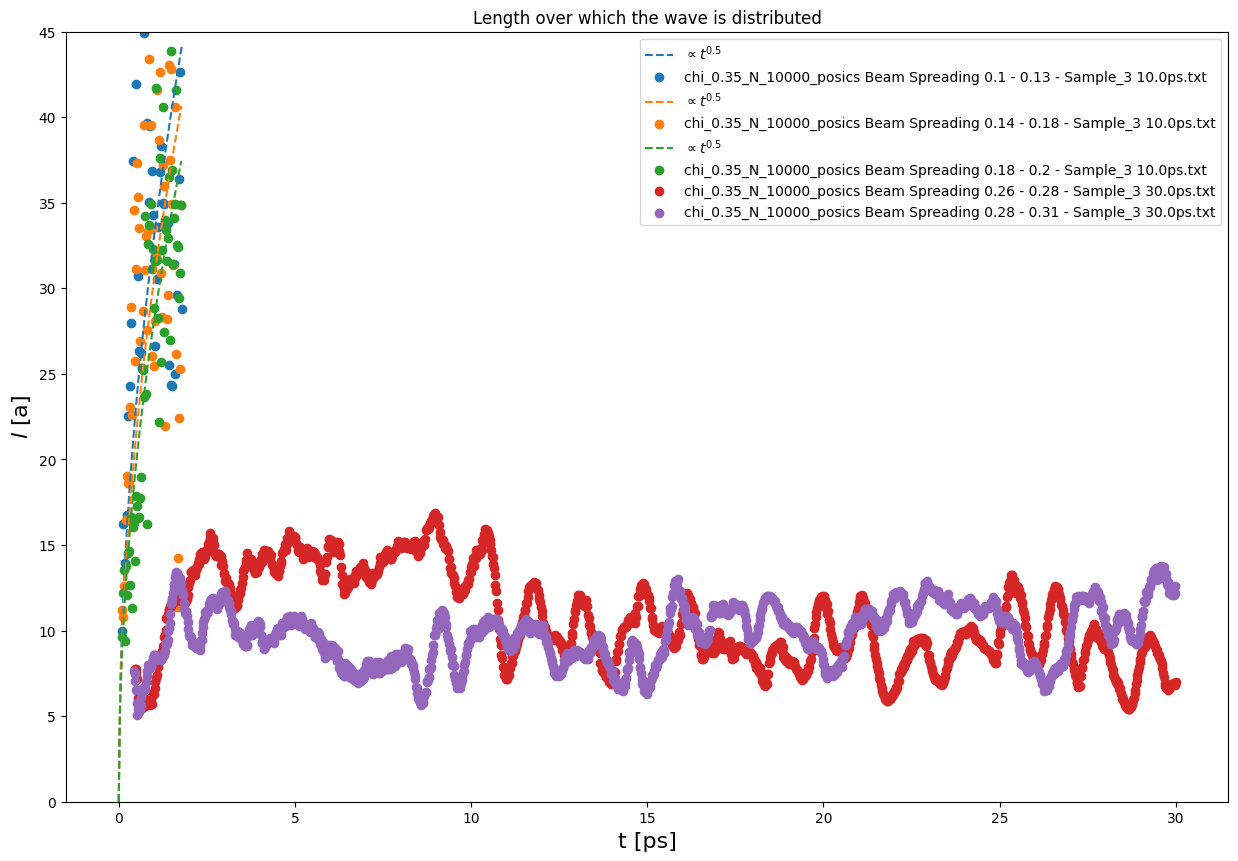

In [14]:
from scipy.optimize import curve_fit
def test(t, b,c):
    return b * t**c

plt.figure(figsize=(15, 10))
for i, item in enumerate(data):
    
    sc = item["field_time_out"].squeeze()
    if i in [0,1,2]:
        sc = (sc[:,:,np.where(np.bool_(sc["t"]<=1.8e-12))[0]].squeeze())
        intensity_exit = sc[:,-1,:].squeeze()
        time = intensity_exit['t'].values*1e12
        ipr = calculate_IPR(intensity_exit)
        inverse_ipr = 1/ipr
        inverse_ipr[np.isnan(inverse_ipr)]=0
        inverse_ipr[np.isinf(inverse_ipr)]=0
        param, param_cov = curve_fit(test, time, inverse_ipr)
        print(param)
        plt.plot(time,test(time,param[0],0.5), '--', label=fr"$ \propto t^{{0.5}}$")
        plt.scatter(time,(1/ipr), label=item['filename'])
        continue
    intensity_exit = sc[:,-1,:].squeeze()
    time = intensity_exit['t'].values*1e12
    ipr = calculate_IPR(intensity_exit)
    plt.scatter(time[19:],moving_average(1/ipr,20), label=item['filename'])

plt.legend()
plt.ylim(0,45)
plt.title("Length over which the wave is distributed")
plt.ylabel(rf"$l$ [a]",fontdict={"fontsize":16})
plt.xlabel(rf"t [ps]",fontdict={"fontsize":16})
plt.show()

<Figure size 1500x1000 with 0 Axes>

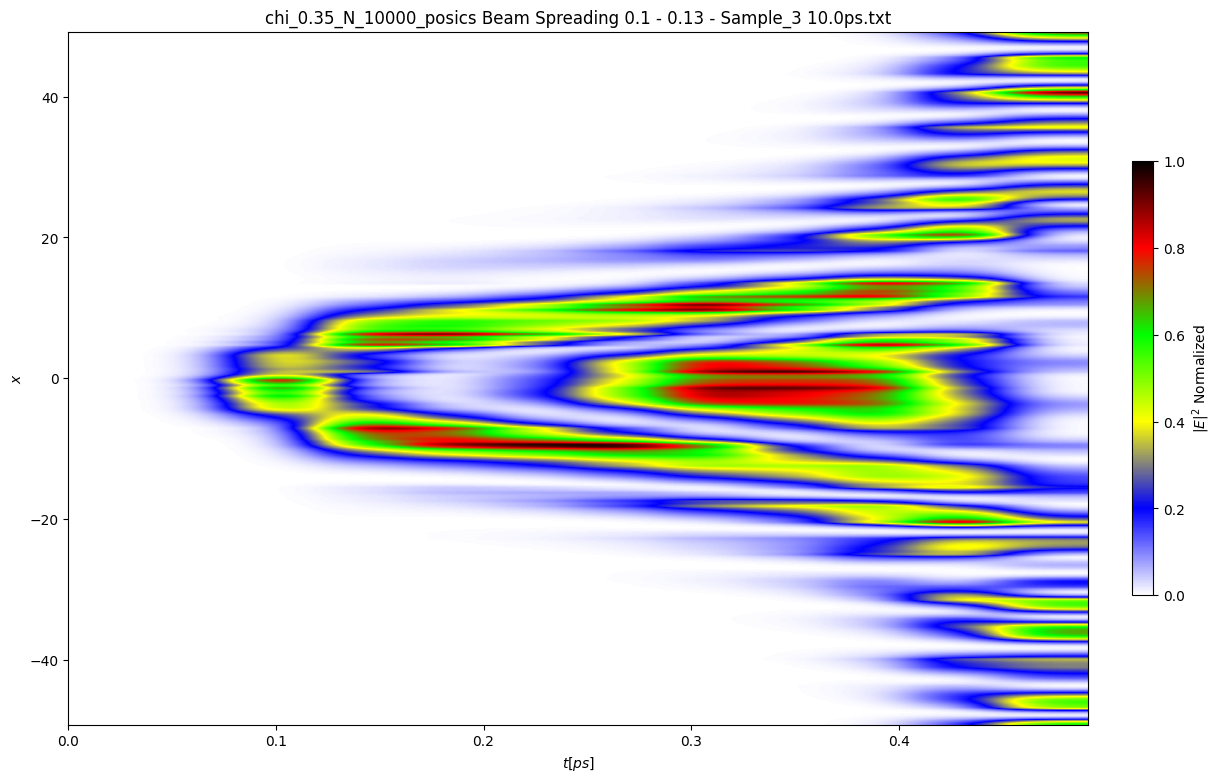

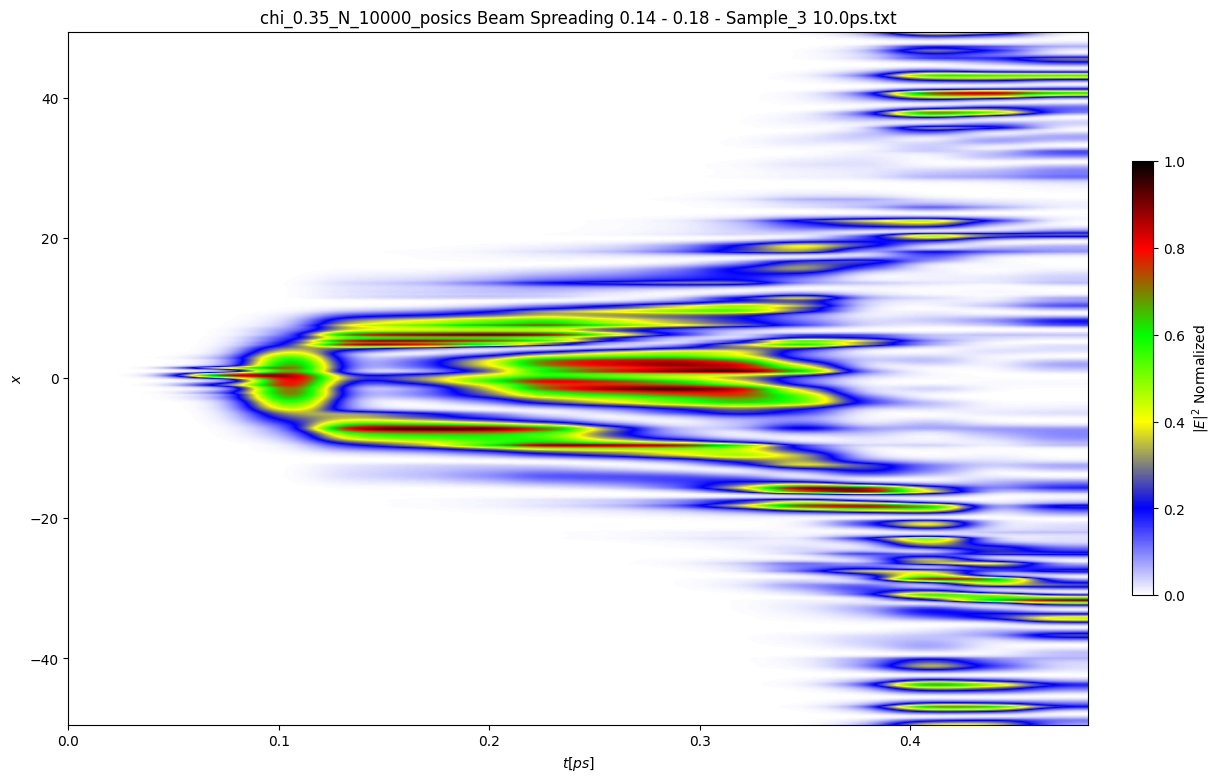

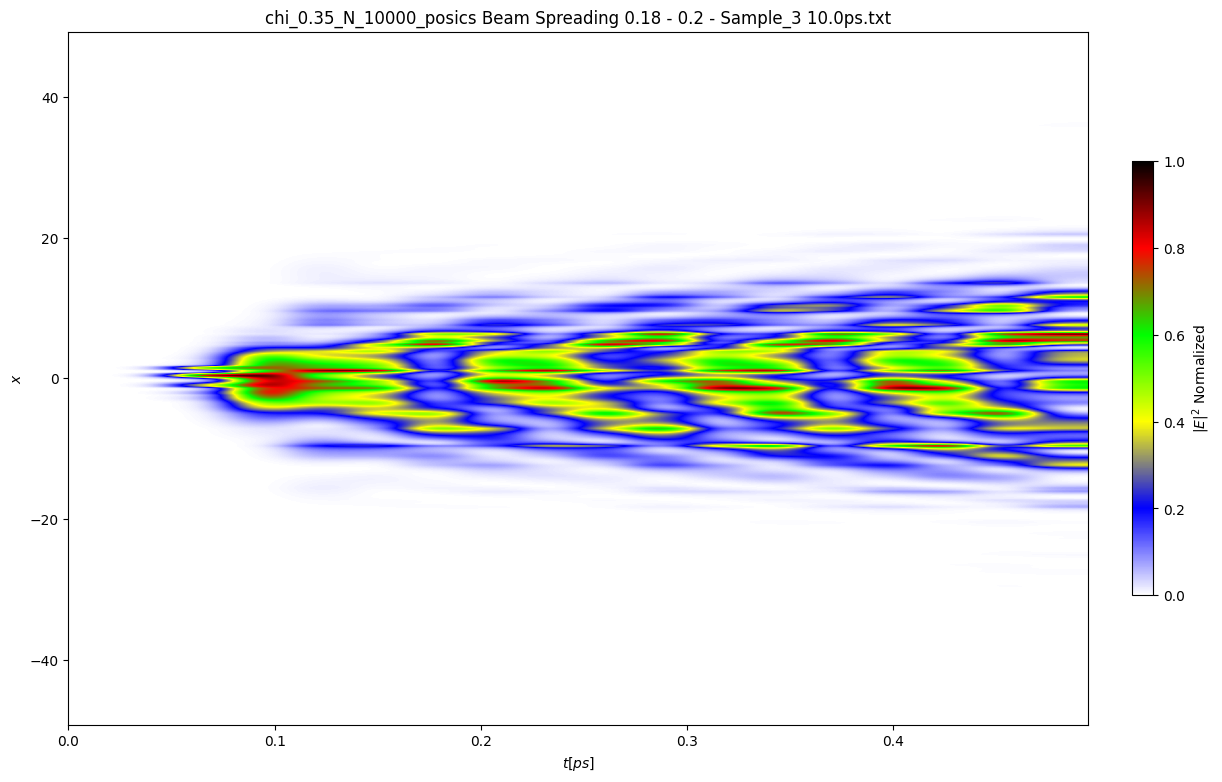

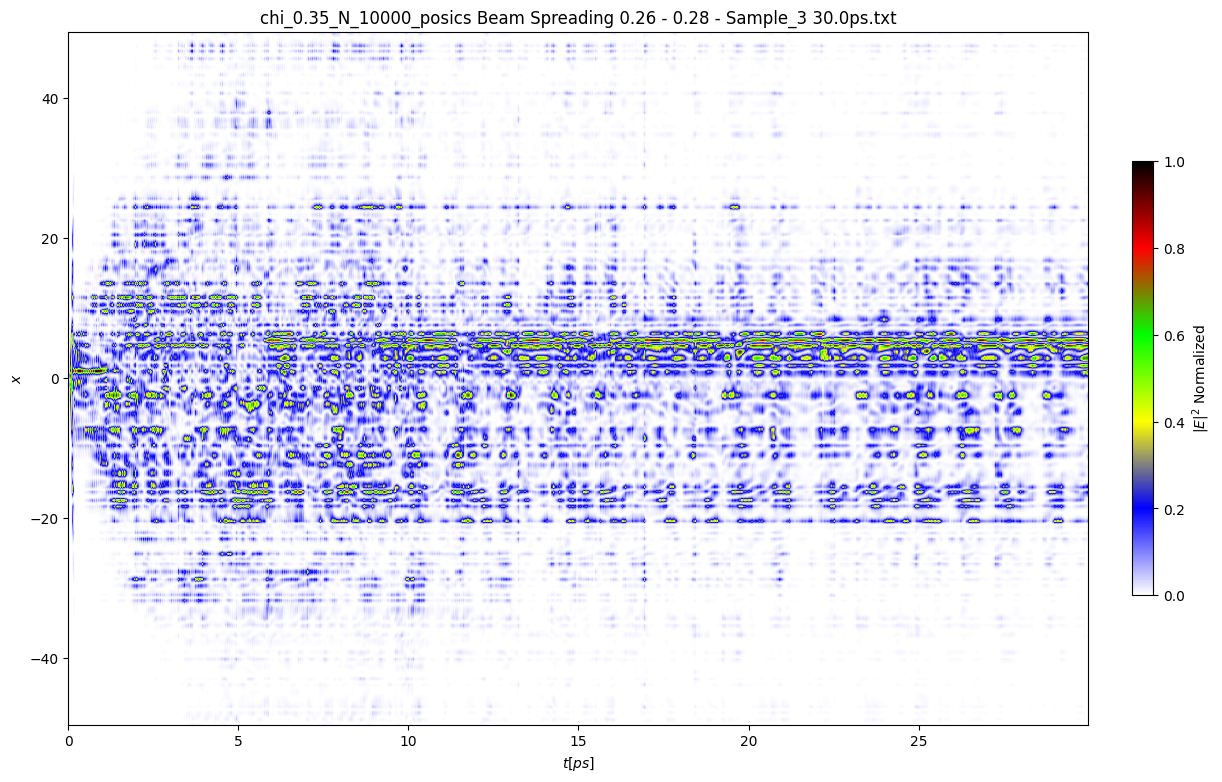

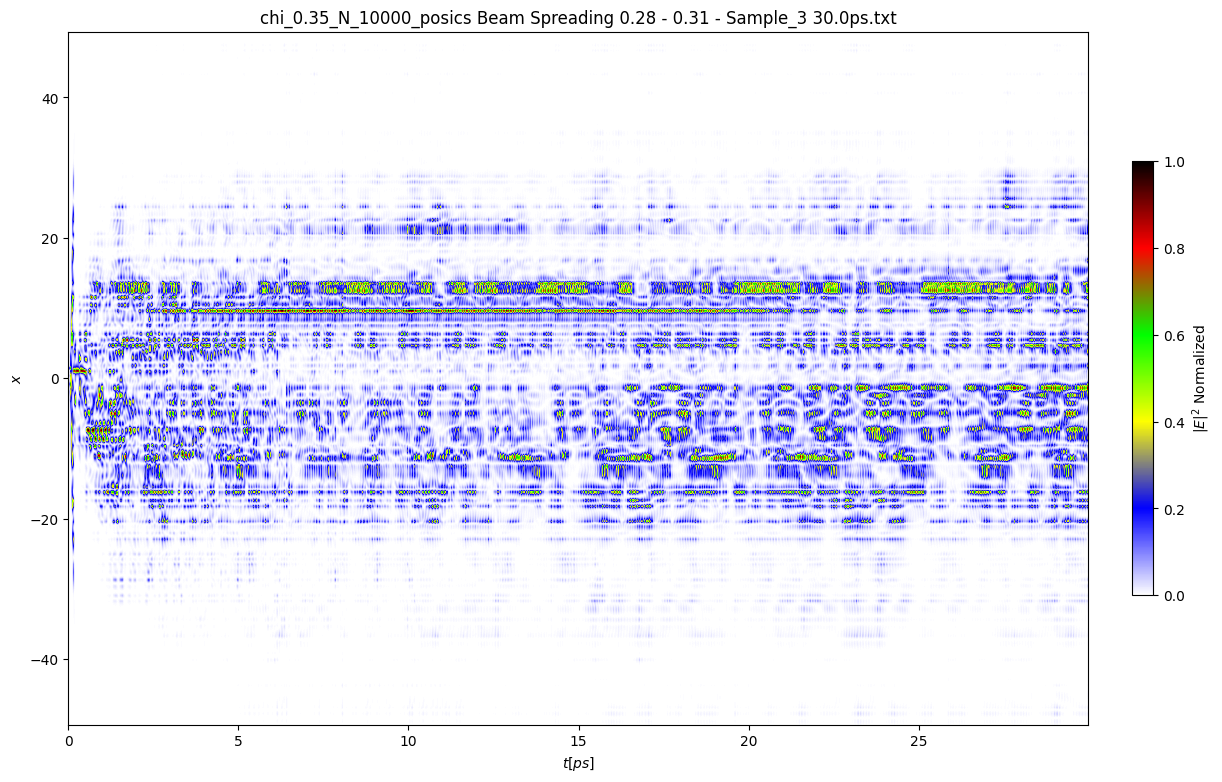

In [15]:
import matplotlib.colors as mcolors
plt.figure(figsize=(15, 10))
for i, item in enumerate(data):
    sc = item["field_time_out"].squeeze()
    sc = sc/np.max(sc,axis=(0))
    
    if i in [0,1,2]:
        sc = (sc[:,:,np.where(np.bool_(sc["t"]<=0.5e-12))[0]].squeeze())
    else:
        sc = (sc[:,:,np.where(np.bool_(sc["t"]>=0e-12))[0]].squeeze())
    intensity_exit = (sc[:,-1,:].squeeze()).values
    intensity_exit[np.isnan(intensity_exit)] = 0
    time = sc['t'].values*1e12
    fig, ax = plt.subplots(figsize=(14,9))
    # Define the colors: Blue -> White -> Yellow -> Green -> Red
    colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  

    # Create a custom colormap
    n_bins = 500  # Number of bins for smooth transition
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

    # (field_loc_length).plot.pcolormesh(ax=ax,cmap=cmap)
    im=plt.imshow(intensity_exit, vmin = np.min(intensity_exit), vmax = np.max(intensity_exit), 
                     extent =[np.min(time),np.max(time),np.min(sc['x'].values),np.max(sc['x'].values)], 
                         origin ='lower', cmap=cmap,aspect='auto', interpolation="gaussian") 
    # Add colorbar for reference
    cbar = fig.colorbar(im, ax=ax, label=rf"$|E|^2$ Normalized",orientation='vertical', fraction=0.02, pad=0.04)

    plt.ylabel(rf"$x$")
    plt.xlabel(rf"$t [ps]$")
    plt.title(item['filename'])

    plt.show()

